<font size=4 face='黑体'>下载inception模型

In [1]:
import tensorflow as tf
import os
import tarfile
import requests

H:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
inception_pretrain_model_url = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'

inception_pretrain_model_dir = "inception_model"
if not os.path.exists(inception_pretrain_model_dir):
    os.makedirs(inception_pretrain_model_dir)

filename = inception_pretrain_model_url.split('/')[-1]
filepath = os.path.join(inception_pretrain_model_dir,filename)

if not os.path.exists(filepath):
    print('download:',filename)
    r = requests.get(inception_pretrain_model_url, stream=True)
    with open(filepath, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
print('finish: ',filename)

#解压文件
tarfile.open(filepath, 'r:gz').extractall(inception_pretrain_model_dir)

#log_dir = 'logs/inception_log'
#if not os.path.exists(log_dir):
   # os.makedirs(log_dir)
    
# classfy_image_graph_def.pb 为google训练好的模型
inception_graph_def_fiel = os.path.join(inception_pretrain_model_dir,'classify_image_graph_def.pb')
with tf.Session() as sess:
    #创建一个图来存放google训练好的模型
    with tf.gfile.FastGFile(inception_graph_def_fiel, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')

download: inception-2015-12-05.tgz
finish:  inception-2015-12-05.tgz


<font size=4 face='黑体'>使用inception-v3对简单的图片进行分类

In [1]:
import tensorflow as tf
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt

H:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


F:\images\\candle.jpg


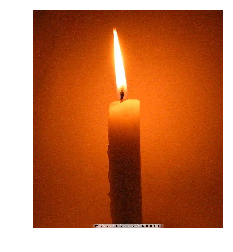

candle, taper, wax light (score = 0.98215)
lighter, light, igniter, ignitor (score = 0.00081)
altar (score = 0.00058)
torch (score = 0.00031)
matchstick (score = 0.00025)
F:\images\\gou.jpg


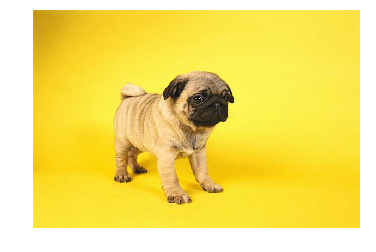

pug, pug-dog (score = 0.87891)
Brabancon griffon (score = 0.01133)
bull mastiff (score = 0.00413)
cheeseburger (score = 0.00114)
French bulldog (score = 0.00081)
F:\images\\house.jpg


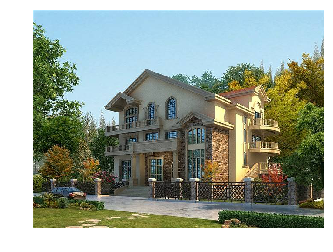

patio, terrace (score = 0.31090)
library (score = 0.22126)
palace (score = 0.09985)
monastery (score = 0.05698)
restaurant, eating house, eating place, eatery (score = 0.04573)
F:\images\\mao.jpg


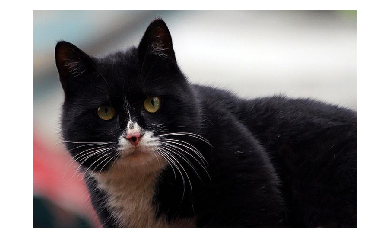

tabby, tabby cat (score = 0.39554)
Egyptian cat (score = 0.29053)
tiger cat (score = 0.06625)
Persian cat (score = 0.00646)
mouse, computer mouse (score = 0.00535)
F:\images\\sandbanch.jpg


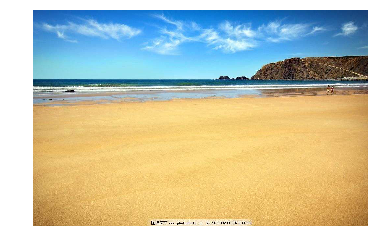

seashore, coast, seacoast, sea-coast (score = 0.95730)
promontory, headland, head, foreland (score = 0.01520)
sandbar, sand bar (score = 0.00556)
cliff, drop, drop-off (score = 0.00114)
beacon, lighthouse, beacon light, pharos (score = 0.00067)


In [5]:
#创建一个连接分类编号和分类描述的类
class NodeLookup(object):
    def __init__(self):
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path,uid_lookup_path)  #load方法在下面定义
        
    def load(self,label_lookup_path,uid_lookup_path):
        #加载字符串对应分类描述的文件
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        #创建字符串与分类描述一一对应的字典
        uid_to_name={}
        #一行一行读取数据
        for line in proto_as_ascii_lines:
            line = line.strip('\n') #去掉换行符
            parsed_items = line.split('\t')
            uid = parsed_items[0] #字符串
            name = parsed_items[1] #分类描述
            uid_to_name[uid] = name
            
        #加载分类编号对应字符串的文件
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        #创建分类编号与字符串一一对应的字典
        node_id_to_uid={}
        for line in proto_as_ascii:
            if line.strip().startswith('target_class:'):
                target_class = int(line.strip().split(":")[1])
            elif line.strip().startswith('target_class_string'):
                target_class_string = line.strip().split(":")[1].strip()
                node_id_to_uid[target_class] = target_class_string[1:-1]
                
        #创建分类编号与分类描述一一对应的字典
        node_id_to_name = {}
        for key,val in node_id_to_uid.items():
            names = uid_to_name[val]
            node_id_to_name[key] = names
            
        return node_id_to_name
    
    #传入分类编号，返回分类描述
    def id_to_string(self,node_id):
        if node_id not in self.node_lookup: #self.node_lookup 得到是一个字典
            return ''
        return self.node_lookup[node_id]
    
#创建一个图来存放Google训练好的模型
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb','rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def,name='')
    
node_lookup = NodeLookup()

with tf.Session() as sess:
    #拿到softmax的op
    #‘softmax：0’这个名字，可以在网络中找到这个节点，它的名字就叫‘（softmax）’,并且是第一个
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    for root,dirs,files in os.walk(r'F:\images\\'):  #walk表示遍历文件夹（root是根目录，dirs是子目录，files是文件）
        for file in files:
            image_data = tf.gfile.FastGFile(os.path.join(root,file),'rb').read()
            #运行softmax节点，向其中feed值
            #可以在网络中找到这个名字，DecodeJpeg/contents，
            #可以发现，根据名字取网络中的op时，如果其名字带括号，就用括号内的名字，如果不带括号，就用右上角介绍中的名字
            #而带个0，是默认情况，如果网络中出现同名节点，这个编号会递增
            predictions = sess.run(softmax_tensor,{'DecodeJpeg/contents:0':image_data})
            predictions = np.squeeze(predictions) #把结果转化为1维数据
            
            image_path = os.path.join(root,file)
            print(image_path)
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            
            #排序
            top_k = predictions.argsort()[-5:][::-1]
            for node_id in top_k:
                name_string = node_lookup.id_to_string(node_id)
                score = predictions[node_id]
                print('%s (score = %.5f)' % (name_string,score))

<font size=4 face='黑体'>利用inception创建自己的分类模型（目前TensorFlow版本太低）